# Predicting Loan Default Using Financial and Demographic Data

##  Import Libraries

In [1]:
# importing required module
import pandas as pd # For working with the data in the DataFrames
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical data visualization
from sklearn.model_selection import train_test_split, cross_val_score  # For splitting of the data and Cross-Validation
from sklearn.preprocessing import StandardScaler, LabelEncoder  # In feature scaling while feature encoding categoric variables
from sklearn.linear_model import LogisticRegression  # For logistic regression model
from sklearn.tree import DecisionTreeClassifier  # For decision tree classification
from sklearn.ensemble import RandomForestClassifier  # For random forest classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve  # Performance for model evaluating


##  Load the Dataset

In [6]:
# Loading our dataset
df = pd.read_csv('lending_club_loan_dataset.csv')

# print the first firt rows to confirm if the data is loaded
df.head()


,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [11]:
df.shape

(20000, 14)

##  Data Preprocessing
### Handle Missing and Duplicates Values

In [8]:
# Check for missing values
print(df.isnull().sum())


id                           0
grade                        0
annual_inc                   0
short_emp                    0
emp_length_num               0
home_ownership            1491
dti                        154
purpose                      0
term                         0
last_delinq_none             0
last_major_derog_none    19426
revol_util                   0
total_rec_late_fee           0
od_ratio                     0
bad_loan                     0
dtype: int64


In [9]:
# Fill missing values in 'home_ownership' with 'Unknown'
df['home_ownership'].fillna("Unknown", inplace=True)

# Handling missing values in 'dti' by filling with the median
df['dti'].fillna(df['dti'].median(), inplace=True)

# Dropping 'last_major_derog_none' column due to high percentage of missing values
df.drop(columns=['last_major_derog_none'], inplace=True)

# Verify that there are no remaining missing values
df.isnull().sum()


id                    0
grade                 0
annual_inc            0
short_emp             0
emp_length_num        0
home_ownership        0
dti                   0
purpose               0
term                  0
last_delinq_none      0
revol_util            0
total_rec_late_fee    0
od_ratio              0
bad_loan              0
dtype: int64

In [64]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


### Encode Categorical Variables

In [12]:
#Imputing missing data in the features like grade, home_ownership, purpose and term
label_encoders = {} # Make an empty dictionary for holding the label encoders of each column
for column in ['grade', 'home_ownership', 'purpose', 'term']: #For each specified column getaway to the next one
    le = LabelEncoder() # First of all, let’s initialize a LabelEncoder instance.
    df[column] = le.fit_transform(df[column]) # Use the LabelEncoder for the column in order to convert values in a column from categorical to numbers
    label_encoders[column] = le # LabelEncoder can be used multiple times so store the fitted object in the dictionary


### Feature Scaling

In [14]:
# Transforming for numerical columns
scaler = StandardScaler() # Standard scalar is used for data normalization where the values in each feature will get a zero mean and unit variance.
numerical_features = ['annual_inc', 'dti', 'emp_length_num', 'revol_util', 'total_rec_late_fee', 'od_ratio'] # The following gives numerical features to standardize:
df[numerical_features] = scaler.fit_transform(df[numerical_features]) # Use the scaler on the numerical features in order to pre process the data

df.head() # The next 5 rows of the DataFrame are displayed to review the transformed data

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,0,0.589645,1,-1.542446,2,1.281718,1,1,1,-0.302926,-0.09349,-1.194963,0
1,9604874,0,0.213517,0,-0.747562,1,-1.481488,1,1,0,-0.818165,-0.09349,1.064764,0
2,9684700,3,0.102891,0,1.107167,0,0.246839,2,2,1,-0.229320,-0.09349,-1.631081,1
3,9695736,3,-0.792381,0,-0.217639,0,-0.569683,6,2,0,-1.074597,-0.09349,0.105857,1
4,9795013,3,-0.184736,0,1.107167,0,-0.704668,2,1,0,-0.967750,-0.09349,-1.174539,0


## Exploratory Data Analysis (EDA)

### Statistical Summary

In [41]:
df.describe()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,2.000000e+04,20000.000000,2.000000e+04,20000.000000,2.000000e+04,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,2.000000e+04,2.000000e+04,2.000000e+04,20000.00000
mean,7.590662e+06,1.987750,8.526513e-17,0.112500,4.742873e-17,1.009500,-1.421085e-18,2.446400,1.248350,0.546600,1.172396e-16,8.881784e-18,1.838529e-16,0.20000
std,1.609593e+06,1.328529,1.000025e+00,0.315989,1.000025e+00,1.069096,1.000025e+00,1.942786,0.435754,0.497836,1.000025e+00,1.000025e+00,1.000025e+00,0.40001
min,5.860400e+05,0.000000,-1.436754e+00,0.000000,-1.807407e+00,0.000000,-2.194787e+00,0.000000,0.000000,0.000000,-1.328654e+00,-9.349026e-02,-1.752976e+00,0.00000
25%,6.206283e+06,1.000000,-5.829883e-01,0.000000,-1.012523e+00,0.000000,-7.523090e-01,2.000000,1.000000,0.000000,-4.073982e-01,-9.349026e-02,-8.587542e-01,0.00000
50%,7.378896e+06,2.000000,-1.847357e-01,0.000000,4.732209e-02,1.000000,-5.224392e-02,2.000000,1.000000,1.000000,2.711181e-02,-9.349026e-02,7.821220e-03,0.00000
75%,8.766235e+06,3.000000,3.241428e-01,0.000000,1.107167e+00,2.000000,7.179601e-01,2.000000,1.000000,1.000000,4.260063e-01,-9.349026e-02,8.666298e-01,0.00000
max,1.145464e+07,6.000000,2.050228e+01,1.000000,1.107167e+00,3.000000,2.435700e+00,11.000000,2.000000,1.000000,1.176274e+02,3.093891e+01,1.722075e+00,1.00000


### Histogam for continous features

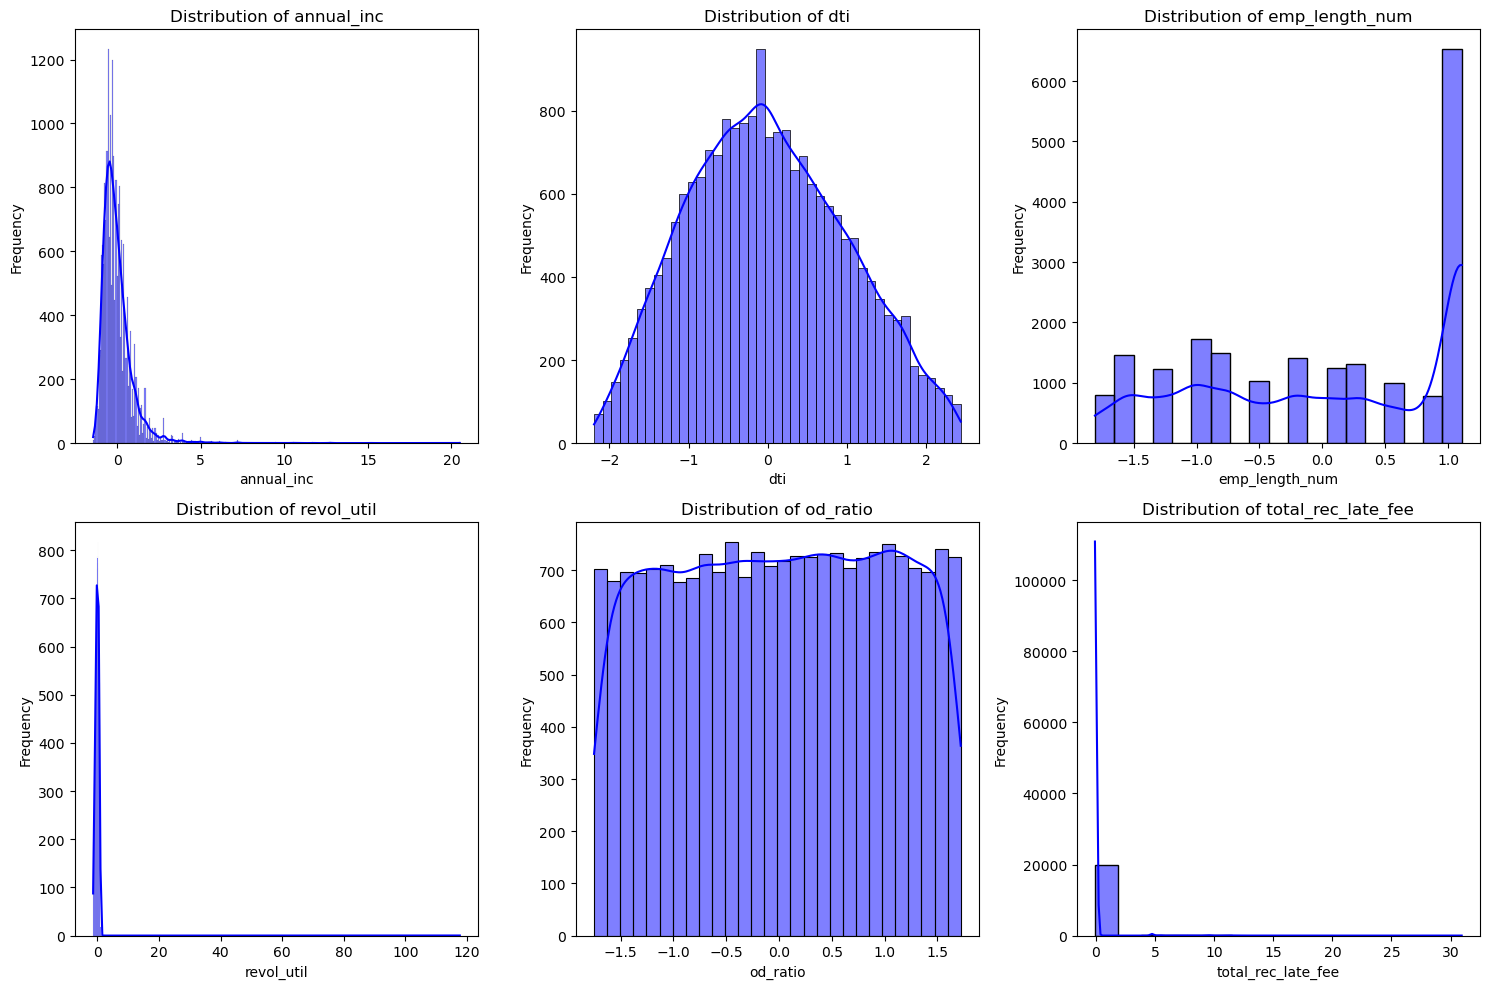

In [42]:
import seaborn as sns # For presenting statistical data
import matplotlib.pyplot as plt # For plotting graphs

# Specifying list of continuous features that we can use to visualize
continuous_features = ['annual_inc', 'dti', 'emp_length_num', 'revol_util', 'od_ratio', 'total_rec_late_fee']

# We can set the figure size for the plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features, 1): # For each feature in the features_list, begin from 1
    plt.subplot(2, 3, i) # Place a subplot grid (2 rows, 3 columns) for every histogram
    sns.histplot(df[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}') # Set the title of the plot
    plt.xlabel(feature) # Add the feature name on the x-axis
    plt.ylabel('Frequency') # It is recommended that on the y-axis we put the ‘Frequency’ label

plt.tight_layout() # Strict some relayouts to avoid an overlap of subplots
plt.show() # Display the plots

### Box plots for continuous features against 'bad_loan' target

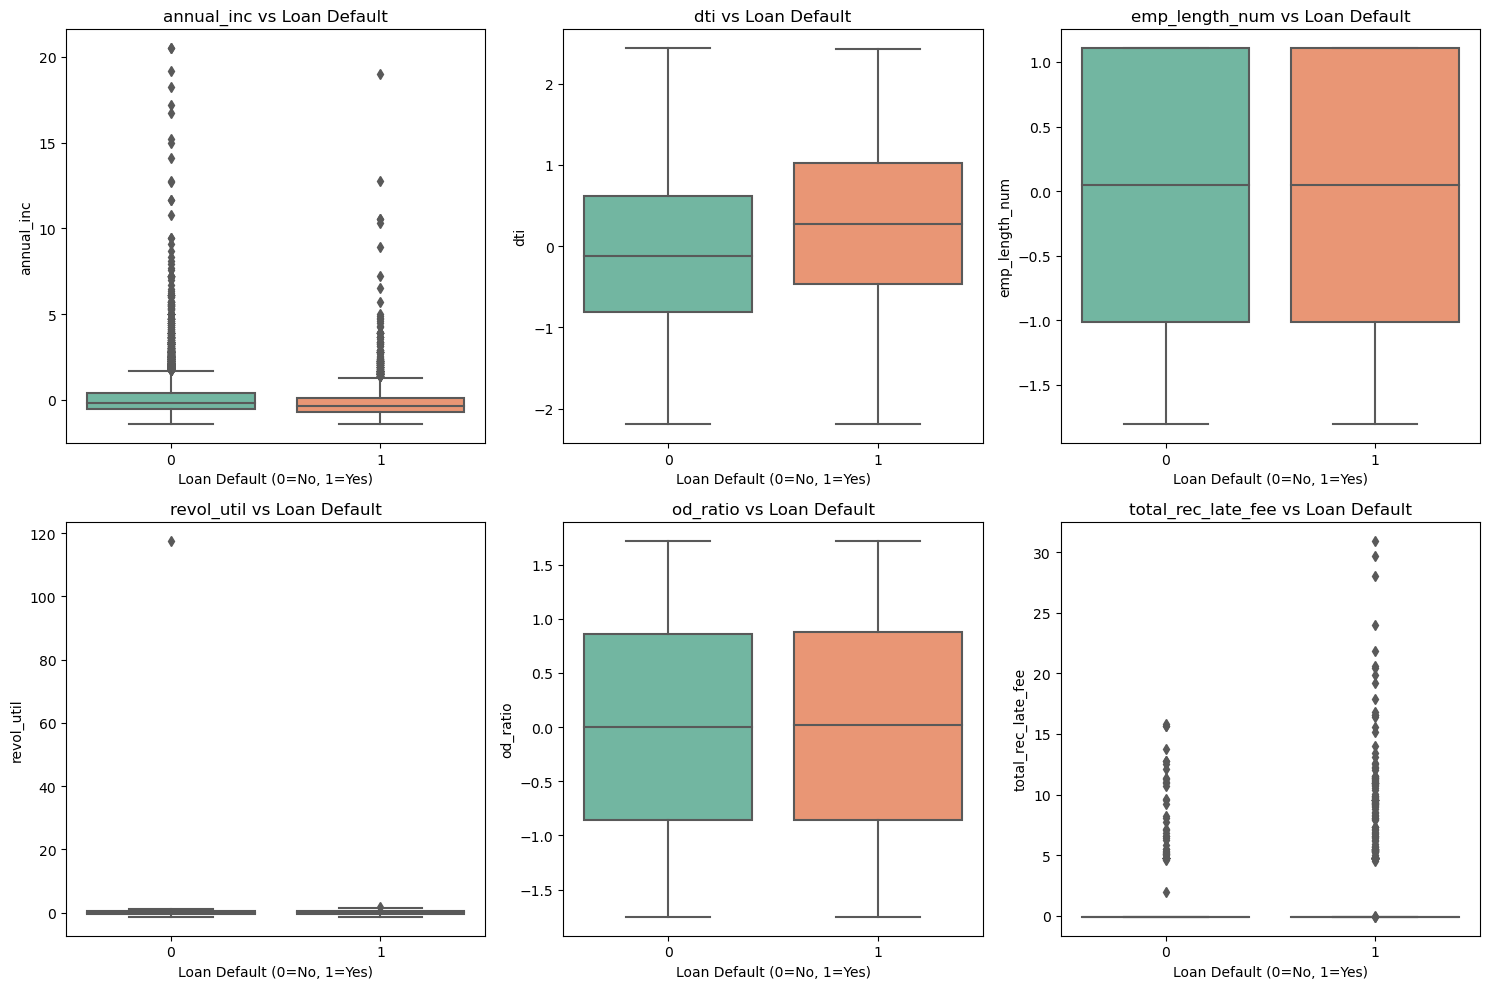

In [43]:
# Box plots for continuous features against 'bad_loan' target
plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='bad_loan', y=feature, data=df, palette='Set2')
    plt.title(f'{feature} vs Loan Default')
    plt.xlabel('Loan Default (0=No, 1=Yes)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


### Correlation Heatmap

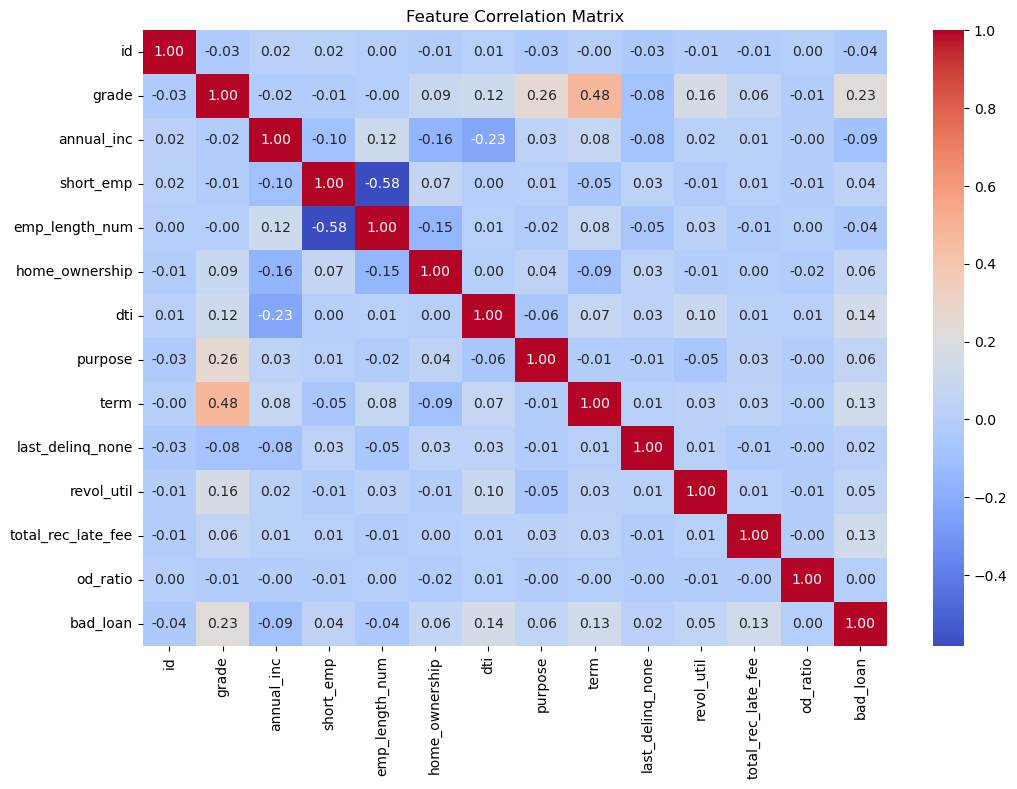

In [15]:
## We also plot a heatmap with the objective of identifying which features are correlated
plt.figure(figsize=(12, 8)) # Next, set the figure size for the heatmap
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f') # Heatmap of correlation with annotations and a selected color map
plt.title("Feature Correlation Matrix") # Specify the title of the heatmap
plt.show()# Display the heatmap


In [47]:
# Correlation matrix with all numeric features and target variable 'bad_loan'
correlation_matrix = df.corr()

# Display correlations with 'bad_loan'
print(correlation_matrix['bad_loan'].sort_values(ascending=False))


bad_loan              1.000000
grade                 0.226760
dti                   0.141371
term                  0.132704
total_rec_late_fee    0.130233
home_ownership        0.061034
purpose               0.057548
revol_util            0.053682
short_emp             0.037186
last_delinq_none      0.021494
od_ratio              0.000403
id                   -0.037307
emp_length_num       -0.041420
annual_inc           -0.092402
Name: bad_loan, dtype: float64


### distribution of the target variable

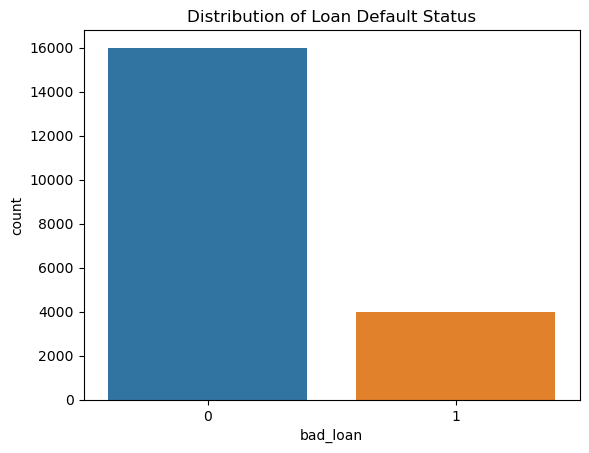

In [16]:
# Plotting distribution of the target variable
sns.countplot(x='bad_loan', data=df)
plt.title("Distribution of Loan Default Status")
plt.show()


## Statistical Methods

### T-tests/ANOVA

In [37]:
from scipy import stats # Importation of the stats module from the scipy platform for conducting the tests

# We split data into the groups of defaulting and non-defaulting samples.
non_default = df[df['bad_loan'] == 0] # We want only rows that have ‘bad_loan’ as 0 as these ares the non-defaulting loans
default = df[df['bad_loan'] == 1] # filters the rows where ‘bad_loan’ is equal to 1, he means that defaulting loans must be eliminated.

#: List of numeric features to test
numeric_features = ['annual_inc', 'dti', 'emp_length_num', 'revol_util', 'od_ratio', 'total_rec_late_fee']

# T- tests for each of the numeric feature
for feature in numeric_features: # Iterate over each numeric metadata
    t_stat, p_value = stats.ttest_ind(non_default[feature], default[feature], equal_var=False) # T-test assuming equal variance
    print(f"T-test for {feature}: t-statistic={t_stat}, p-value={p_value}") # Both, t-statistic and p-value to be produced for each feature



T-test for annual_inc: t-statistic=13.906641007476617, p-value=2.330462172995705e-43
T-test for dti: t-statistic=-20.01755080443992, p-value=2.2190953275761987e-86
T-test for emp_length_num: t-statistic=5.779495145381665, p-value=7.866256302343938e-09
T-test for revol_util: t-statistic=-11.221840213844029, p-value=4.3098071218782027e-29
T-test for od_ratio: t-statistic=-0.056963000008254765, p-value=0.9545765225889691
T-test for total_rec_late_fee: t-statistic=-10.295139152231751, p-value=1.4661747307178915e-24


In [40]:
from scipy.stats import f_oneway

# Data partition into defaulting and non – defaulting cohorts
non_default = df[df['bad_loan'] == 0]
default = df[df['bad_loan'] == 1] # Exclude those rows that have values 1 in ‘bad_loan’, which is defaulting loans.

#List of numeric features to test
numeric_features = ['annual_inc', 'dti', 'emp_length_num', 'revol_util', 'od_ratio', 'total_rec_late_fee']

# For each numeric feature, do ANOVA
for feature in numeric_features:
    # Applying ANOVA: We are testing equality of means of numeric variables between defaulting and non-defaulting borrowers
    f_stat, p_value = f_oneway(non_default[feature], default[feature])
    print(f"ANOVA for {feature}: F-statistic={f_stat}, p-value={p_value}")


ANOVA for annual_inc: F-statistic=172.21521689873916, p-value=3.526286115325545e-39
ANOVA for dti: F-statistic=407.8255834916587, p-value=8.565020652747574e-90
ANOVA for emp_length_num: F-statistic=34.36798641116676, p-value=4.63335959570931e-09
ANOVA for revol_util: F-statistic=57.79640354820724, p-value=3.035072594940507e-14
ANOVA for od_ratio: F-statistic=0.0032556501367073574, p-value=0.954499320362893
ANOVA for total_rec_late_fee: F-statistic=345.02944390725895, p-value=2.2504230421138736e-76


### Chi-Square Test

In [39]:
# # Necessary function we will be using to perform Chi-Square tests is the chi2_contingency from scipy.stats
from scipy.stats import chi2_contingency

# Features by category
categorical_features = ['grade', 'home_ownership', 'purpose', 'term', 'last_delinq_none']

# Iteration through each feature of the particular description – categorical features
for feature in categorical_features: # In each case, the next step should be running a Chi-Square Test on each of the categorical features.
    contingency_table = pd.crosstab(df[feature], df['bad_loan'])  # Create contingency table for the feature and the target variable ‘bad_loan’,
    chi2, p, dof, expected = chi2_contingency(contingency_table) # Chi-square Test of independence #
    print(f"Chi-Square Test for {feature} vs bad_loan: chi2={chi2}, p-value={p}") # Show the test findings (chi2 statistic and acceepted p-value)


Chi-Square Test for grade vs bad_loan: chi2=1043.4871531168008, p-value=3.5090756882127464e-222
Chi-Square Test for home_ownership vs bad_loan: chi2=109.85772213055522, p-value=1.177483227238468e-23
Chi-Square Test for purpose vs bad_loan: chi2=90.05655223878915, p-value=1.625153100822036e-14
Chi-Square Test for term vs bad_loan: chi2=354.59024588660384, p-value=1.0039369467339699e-77
Chi-Square Test for last_delinq_none vs bad_loan: chi2=9.131833800027149, p-value=0.0025119980621080926


## Predictive Model

### Splitting Data

In [48]:
# Define features and target 
X = df[['grade', 'dti', 'term', 'total_rec_late_fee', 'annual_inc', 'home_ownership', 'purpose', 'revol_util']]
y = df['bad_loan']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
import warnings
# Disable all warnings
warnings.filterwarnings("ignore")

### Logistic Regression

In [58]:
# we will initialize the Logistic Regression model setting a maximum number of iterations at 500
log_model = LogisticRegression(max_iter=500)
# In the training data used in the study, the following model was trained
log_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_model.predict(X_test) # Forecast the output variable for the test data

# Evaluation
print("Logistic Regression Classification Report:") # Provide a classification report of Logistic Regression
print(classification_report(y_test, y_pred_log)) # Print out the classification metrics which includes Precision,Recall and f1-score
print("Logistic Regression ROC-AUC Score:", roc_auc_score(y_test, y_pred_log)) # Print out the ROC-AUC score for the end model which is Logistic Regression


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3210
           1       0.51      0.06      0.10       790

    accuracy                           0.80      4000
   macro avg       0.66      0.52      0.50      4000
weighted avg       0.75      0.80      0.73      4000

Logistic Regression ROC-AUC Score: 0.5221045782562405


### Decision Tree

In [59]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# Predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluation
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))
print("Decision Tree ROC-AUC Score:", roc_auc_score(y_test, y_pred_tree))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      3210
           1       0.26      0.28      0.27       790

    accuracy                           0.70      4000
   macro avg       0.54      0.54      0.54      4000
weighted avg       0.71      0.70      0.70      4000

Decision Tree ROC-AUC Score: 0.54271658977089


### Random Forest

In [60]:
forest_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)

# Predictions
y_pred_forest = forest_model.predict(X_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_forest))
print("Random Forest ROC-AUC Score:", roc_auc_score(y_test, y_pred_forest))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      3210
           1       0.43      0.09      0.16       790

    accuracy                           0.80      4000
   macro avg       0.62      0.53      0.52      4000
weighted avg       0.74      0.80      0.74      4000

Random Forest ROC-AUC Score: 0.5322035569225916


### Model Evaluation and Comparison

#### ROC Curves

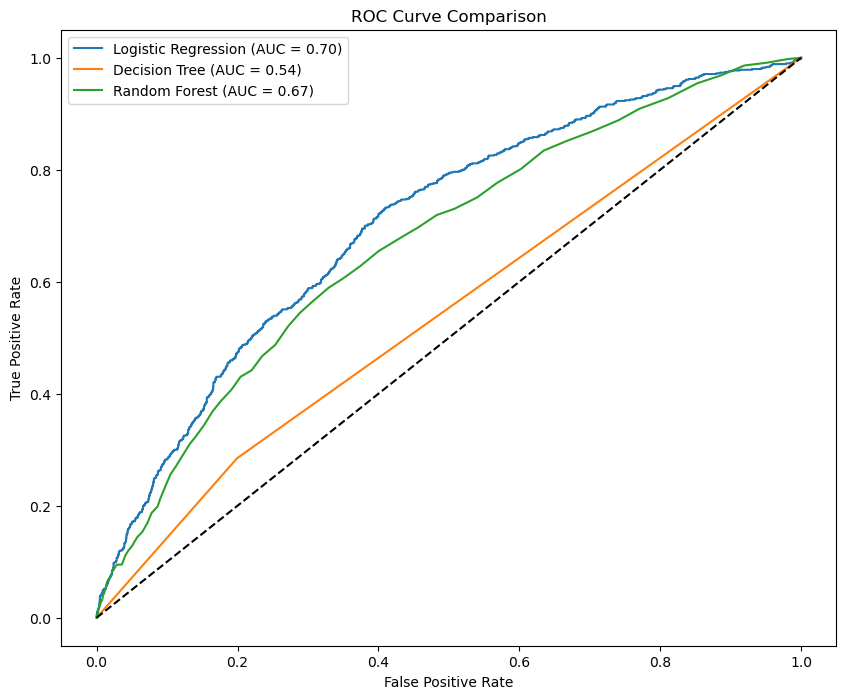

In [61]:
# Next the ROC curve will be plotted for each model.
plt.figure(figsize=(10, 8))  # Figure size of the plot

# Create a dictionary of models
models = {
    "Logistic Regression": log_model,  # Logistic Regression model
    "Decision Tree": tree_model,  # Decision Tree model
    "Random Forest": forest_model  # Random Forest model
}

# For each model, the following will plot its ROC curve
for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Extract probabilities of the positive class
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)  # Measure of False Positive Rate and True Positive Rate
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})")  # Plot the ROC curve with AUC

plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line for making the decision boundary of a random classifier.
plt.xlabel('False Positive Rate')  # Label the x-axis
plt.ylabel('True Positive Rate')  # Label the y-axis
plt.title("ROC Curve Comparison")  # Set the title of the plot
plt.legend()  # Display the legend
plt.show()  # Show the plot


#### Confusion Matrices

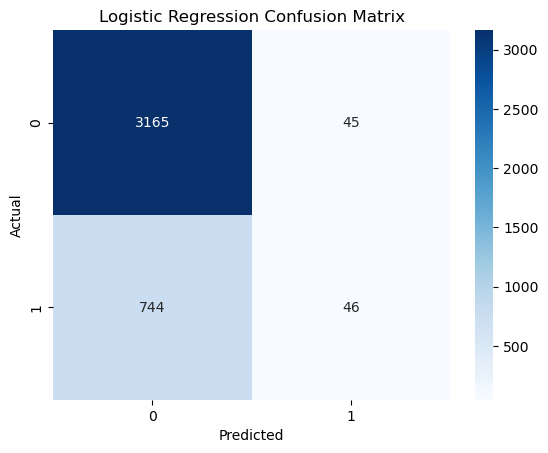

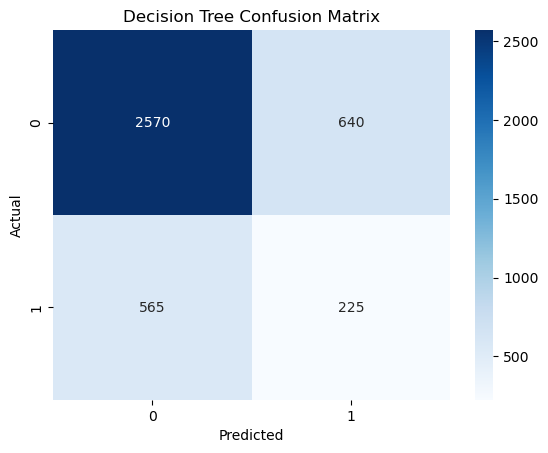

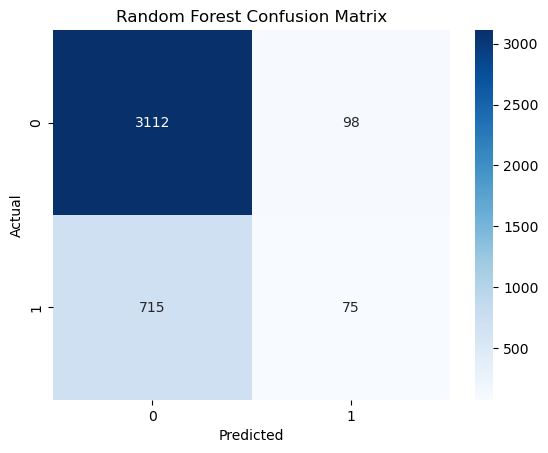

In [62]:
# Display confusion matrices
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


#### Cross-Validation

In [63]:
# Using other methods of cross-validation for the model’s stability
for model_name, model in models.items(): ## For every model, in the dictionary of models,
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc') # 5 In addition, use 5-fold cross validation, set the scoring to be ROC AUC.
    print(f"{model_name} Cross-Validated AUC: {cv_scores.mean():.2f}") # Print the average ROC AUC score of over the 5 folds

    

Logistic Regression Cross-Validated AUC: 0.70
Decision Tree Cross-Validated AUC: 0.55
Random Forest Cross-Validated AUC: 0.66
